In [3]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly
from astropy.cosmology import WMAP9 as cosmo
from pandas.core.frame import DataFrame
from scipy.optimize import curve_fit
from scipy import integrate
#1pixel=0.25arcsec

ModuleNotFoundError: No module named 'plotly'

In [2]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm
#绘制天区图像用

In [3]:
def calculate_flux_per_frequency(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_flux_per_wavelength(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

def calculate_SB(mag,corresponding_lambda,delta_lambda,area):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    surface_brightness=flux/(area*0.25*0.25)
    return surface_brightness
    
# unit： erg per second per quare centimeter per suqare arcsec

In [4]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [5]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [6]:
def show_nebula(img1,img2,img3,x,y,size):
    norm1 = Scaleimgconverter(img1)
    norm2 = Scaleimgconverter(img2)
    norm3 = Scaleimgconverter(img3)
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],norm=norm1,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],norm=norm2,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],norm=norm3,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

## 将cat文件转换为csv文件

In [2]:
with open("BOSS1441_NB.csv",'w+',newline='') as csvfile:#创建一个新的csv文件
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('1441nb_d1.0.cat','r',encoding = 'utf-8') as f:#打开那个.cat文件
        linelist = f.readlines()[13:]#从第十三行读起
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split() #split（）函数，按括号中的内容分割，strip函数，移除头尾指定的字符
            spamwriter.writerow(line_list)

In [8]:
with open("BOSS1441_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('1441bw_d1.0.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [9]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS1441_Bw=pd.read_csv("BOSS1441_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS1441_NB=pd.read_csv("BOSS1441_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])#读取哪几列

In [10]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)#计算bmag
#axis： 需要合并链接的轴，0是行，1是列 

SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']
#bmag是到这儿才加上来的


In [11]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
#不乘u.degree会报错，但为什么也不是很清楚
coord_bw=SkyCoord(ra=BOSS1441_Bw['ALPHA_J2000']*u.degree, dec=BOSS1441_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS1441_NB['ALPHA_J2000']*u.degree, dec=BOSS1441_NB['DELTA_J2000']*u.degree)

In [12]:
print(coord_sdss)

<SkyCoord (ICRS): (ra, dec) in deg
    [(220.497287, 39.715065), (220.482415, 39.700193),
     (220.511518, 39.733417), ..., (220.10637 , 40.31191 ),
     (220.040775, 40.289004), (220.040775, 40.289004)]>


In [13]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)


In [14]:
print(idx)#相匹配之点的indices

[  756    40  1866 ... 63968 63755 63755]


In [15]:
print(d2d)#相匹配两点之间的2d距离

[0d00m42.9901s 0d01m33.9092s 0d00m00.1446s ... 0d05m24.972s 0d04m02.485s
 0d04m02.485s]


In [16]:
print(d3d)#相匹配两点之间的3d距离，无量纲，貌似没什么用

[2.08422070e-04 4.55284442e-04 7.00873738e-07 ... 1.57550861e-03
 1.17560056e-03 1.17560056e-03]


In [17]:
index = np.where((d2d < Angle('0d00m0.5s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))#把其中符合条件的摘出来，即用index来标出距离足够小的object

In [18]:
idx=idx[index]#可以认为是同一个object的点的indices

In [19]:
SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj#SDSS的RA
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj#SDSS的DEC
SDSS6_bmag=SDSS6.bmag.data.obj#SDSS的bmag
BOSS1441_Bw_list=BOSS1441_Bw.MAG_APER.data.obj#BOSS的Bw Mag

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [20]:
BOSS1441_Bw_list_standard=BOSS1441_Bw.MAG_APER.data.obj[idx]#BOSS中可被认为是相同object的部分
SDSS6_bmag_standard=SDSS6_bmag[index]#SDSS中可被认为是相同object的部分

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [21]:
zeropoint_bw=SDSS6_bmag_standard-BOSS1441_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

In [22]:
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation

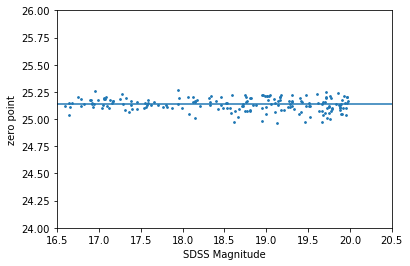

Bw的zeropoint为 25.13518084
Bw的standard deviation为 0.06008385005900087


In [23]:
plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)
plt.axis([16.5, 20.5, 24, 26])
plt.show()

print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

In [24]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,BOSS1441_Bw.MAG_APER+zp_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']
#重写Bw的dataframe，把加了zp的真实mag扔进去，新的一列就叫standard_mag

In [25]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m02s'))
idx_nb=idx_nb[index_nb]

In [26]:
BOSS1441_NB_match = BOSS1441_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS1441_NB_match < 5) &(BOSS1441_NB_match > 0))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS1441_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS1441_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [27]:
zeropoint_nb=mag_bw_standard_select-mag_nb_standard_select
zeropoint_nb=sigma_clip(zeropoint_nb, sigma=3, iters=10)

In [28]:
zp_nb=np.mean(zeropoint_nb)
zp_std_nb=np.std(zeropoint_nb)

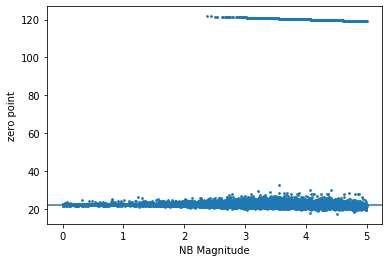

NB的zeropoint为 22.26922889641555
NB的standard deviation为 0.5259199586772351


In [29]:
plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')
plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)
#plt.axis([0,5.5,18,30])
plt.show()

print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

In [30]:
BOSS1441_NB=pd.concat([BOSS1441_NB,BOSS1441_NB.MAG_APER+zp_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [31]:
BOSS1441_NB_match=BOSS1441_NB_match+zp_nb
mag_nb_draw=BOSS1441_NB_match

In [32]:
flux_bw=[]
flux_nb=[]

for i in range(len(BOSS1441_Bw.standard_mag.data.obj)):#对里面所有的点，求bw flux
    flux_bw.append(calculate_flux(BOSS1441_Bw.standard_mag.data.obj[i],4135,1278))
    
for i in range(len(BOSS1441_NB.standard_mag.data.obj)):#对里面所有的点,求nb flux
    flux_nb.append(calculate_flux(BOSS1441_NB.standard_mag.data.obj[i],4030,45))

flux_bw=DataFrame(flux_bw)#转换格式
flux_nb=DataFrame(flux_nb)#转换格式

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [33]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,flux_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

BOSS1441_NB=pd.concat([BOSS1441_NB,flux_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']

In [34]:
#至此，分别计算出了NB和Bw中每个object的flux，并放入了各自的DataFrame中

In [35]:
F_bw=BOSS1441_Bw.flux_bw.data.obj[idx_nb]
F_nb=BOSS1441_NB.flux_nb.data.obj[index_nb]

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [36]:
cont_flux_per_wavelength=[]
for i in range(len(F_bw)):
    #cont_flux_per_wavelength.append((F_bw[i]-F_nb[i])/(1278-45))
    cont_flux_per_wavelength.append(calculate_continuum_flux_density(F_bw[i],F_nb[i],1278,45))
    
#得到了continuum flux density,下面要反求magnitude

In [37]:
#idx_nb是全部可以配对的Bw emitter
#index_nb是与之相对应的全部可以配对的NB emitter

In [38]:
print(len(cont_flux_per_wavelength))
print(len(mag_nb_draw))
print(len(BOSS1441_Bw.standard_mag.data.obj[idx_nb]))
print(len(BOSS1441_NB.standard_mag.data.obj[index_nb]))
#所以我想干脆弄一个新的DataFrame

47359
47359
47359
47359


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [39]:
#把这些搞到一个列表里方便使用

In [40]:
Bw_1=pd.DataFrame()
NB_1=pd.DataFrame()

In [41]:
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.X_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.Y_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ALPHA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.DELTA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLUX_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLUXERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.MAG_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.MAGERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLAGS.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.NITER_MODEL.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ISOAREA_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ISOAREAF_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.standard_mag.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.flux_bw.data.obj[idx_nb])],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will 

In [42]:
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.X_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.Y_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ALPHA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.DELTA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLUX_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLUXERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.MAG_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.MAGERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLAGS.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.NITER_MODEL.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ISOAREA_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ISOAREAF_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.standard_mag.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.flux_nb.data.obj[index_nb])],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will 

In [43]:
#现在的Bw_1,NB_1就是还没有去掉那几个负值的时候的Bw_cont-NB的所有点

In [44]:
minus_number=[]
for i in range(len(cont_flux_per_wavelength)):
    if (cont_flux_per_wavelength[i]<0):
        #print(cont_flux_per_wavelength[i])
        minus_number.append(i)
print(len(minus_number))

819


In [45]:
nb_xaxis=mag_nb_draw.tolist()#转为list格式，方便操作

In [46]:
cont_flux_per_frequency=[]
for i in range(len(cont_flux_per_wavelength)):
    cont_flux_per_frequency.append((cont_flux_per_wavelength[i]*(4135**2)/(3e8*1e10)))
    
#把cont_flux_per_wavelength转为 per frequency

In [47]:
Bw_1.drop(minus_number,inplace=True)
NB_1.drop(minus_number,inplace=True)

In [48]:
for j in range(len(minus_number)):
    length=len(cont_flux_per_frequency)
    for i in range(length):
            if cont_flux_per_frequency[i]<0:
                del cont_flux_per_frequency[i]
                del nb_xaxis[i]
                break

#因为定义域的问题删掉那些不能被log运算的负值,下面那个是错误的做法，因为删除元素本身会影响到cont_flux_per_frequency的长度，所以要用一个
#嵌套循环

In [49]:
#这时的NB_1和Bw_1删掉了flux为负的部分，完全和Bw-NB图一致了

In [50]:
'''
for i in range(len(cont_flux_per_frequency[i])):
    if cont_flux_per_frequency[i]<0:
        del cont_flux_per_frequency[i]
        del nb_xaxis[i]
        length=length-1
'''
#错误做法

'\nfor i in range(len(cont_flux_per_frequency[i])):\n    if cont_flux_per_frequency[i]<0:\n        del cont_flux_per_frequency[i]\n        del nb_xaxis[i]\n        length=length-1\n'

In [51]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_flux_per_frequency)],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(cont_flux_per_wavelength)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength']

NB_1=pd.concat([NB_1,DataFrame(cont_flux_per_frequency)],axis=1)
NB_1=pd.concat([NB_1,DataFrame(cont_flux_per_wavelength)],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength']

In [52]:
#把那个continnum flux也放进去了

In [53]:
cont_bw=[]
for i in range(len(cont_flux_per_frequency)):
    cont_bw.append((-2.5*math.log(cont_flux_per_frequency[i],10)-48.6))

# 这是根据cont_flux_per_frequency计算的continuum Bw magnitude

In [54]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_bw)],axis=1)
NB_1=pd.concat([NB_1,DataFrame(cont_bw)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']



In [55]:
bw_sub_nb=[]
for i in range(len(cont_bw)):
    bw_sub_nb.append(cont_bw[i]-nb_xaxis[i])

#continuum_Bw-NB magnitude

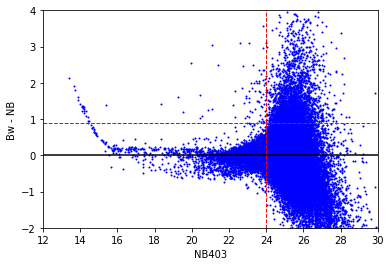

In [56]:
plt.scatter(nb_xaxis, bw_sub_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(24, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [57]:
w = WCS('bwcut.fits')
data,header=fits.getdata('bwcut.fits',header=True)
data2,header2=fits.getdata('nbcut.fits',header=True)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
#datacut=10**((zp_bw - zp_nb)/2.5) * data2-data2

norm = Scaleimgconverter(datacut)

lenx=len(data[0])
leny=len(data)
#最后两行暂时不知道有啥用

In [58]:
'''
hdu = fits.PrimaryHDU(datacut)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('datacut1441.fits')
'''
#创建datacut.fits用

"\nhdu = fits.PrimaryHDU(datacut)\nhdu.header=header2\nhdul = fits.HDUList([hdu])\nhdul.writeto('datacut1441.fits')\n"

In [59]:
index_candidate=[]
for i in range(len(idx_nb)):
    if (Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i] > 0.9) \
        & (NB_1.standard_mag.data.obj[i]< 24):
        if choose(datacut,NB_1.X_IMAGE.data.obj[i],NB_1.Y_IMAGE.data.obj[i],-10,40):
            index_candidate.append(i)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [60]:
Bw_2=pd.DataFrame()
NB_2=pd.DataFrame()

In [61]:
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.X_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUX_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAG_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLAGS.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.standard_mag.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.flux_bw.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_bw.data.obj[index_candidate])],axis=1)
Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']




/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will 

In [62]:
NB_2=pd.concat([NB_2,DataFrame(NB_1.X_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUX_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAG_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLAGS.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.standard_mag.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.flux_nb.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_bw.data.obj[index_candidate])],axis=1)
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']




/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will 

In [63]:
NB_2=pd.concat([NB_2,NB_2.flux_nb-(NB_2.cont_flux_per_wavelength*48)],axis=1)
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux']



In [64]:
#NB2,Bw2是左上角的candidates

In [65]:
#下面一步，就是先把左上角的那些点摘出来，也就是得到emitter
#筛选的条件要求，NB403在18-24之间，Bw-NB大于0.9，且对AREA要求大于25，而且choose那个函数也可以用一用，尽管意义不大

In [66]:
with open("BOSS1441_datacut.csv",'w+',newline='') as csvfile:#创建一个新的csv文件
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('datacut1441_1.0.cat','r',encoding = 'utf-8') as f:#打开那个.cat文件
        linelist = f.readlines()[13:]#从第十三行写起
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()#split（）函数，按括号中的内容分割，strip函数，移除头尾指定的字符
            spamwriter.writerow(line_list)

In [67]:
BOSS1441_datacut=pd.read_csv("BOSS1441_datacut.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])#读取哪几列

In [68]:
coord_datacut=SkyCoord(ra=BOSS1441_datacut['ALPHA_J2000']*u.degree, dec=BOSS1441_datacut['DELTA_J2000']*u.degree)

In [69]:
idx_datacut, d2d_datacut, d3d_datacut = coord_nb.match_to_catalog_sky(coord_datacut)
index_datacut = np.where(d2d_datacut < Angle('0d0m02s'))
idx_datacut=idx_datacut[index_datacut]

#datacut中能够与nb中object匹配的全部object

In [70]:
datacut_1=pd.DataFrame()

datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.X_IMAGE.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.Y_IMAGE.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.ALPHA_J2000.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.DELTA_J2000.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.FLUX_APER.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.FLUXERR_APER.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.MAG_APER.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.MAGERR_APER.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.FLAGS.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.NITER_MODEL.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.ISOAREA_IMAGE.data.obj[idx_datacut])],axis=1)
datacut_1=pd.concat([datacut_1,DataFrame(BOSS1441_datacut.ISOAREAF_IMAGE.data.obj[idx_datacut])],axis=1)

datacut_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [71]:
#NB_1 NB所有显示在图上的点的信息
#Bw_1 Bw所有显示在图上的点的信息
#NB_2 NB所有在图左上角的点的信息
#Bw_2 Bw所有在图左上角的点的信息
#datacut_1 continuum subtracted field中选出来的那点的信息

In [72]:
emitter_1=pd.DataFrame()
emitter_bw=pd.DataFrame()
emitter_nb=pd.DataFrame()
'''
for i in range(len(NB_2)):
    abs_value=[]
    for j in range(len(datacut_1)):
        abs_value.append(abs(datacut_1.X_IMAGE.data.obj[j]-NB_2.X_IMAGE.data.obj[i])+abs(datacut_1.Y_IMAGE.data.obj[j]-NB_2.Y_IMAGE.data.obj[i]))
    k=min(abs_value)
    emitter_1 = pd.concat([emitter_1,datacut_1.loc[k-1:k]],ignore_index = True)
'''

'\nfor i in range(len(NB_2)):\n    abs_value=[]\n    for j in range(len(datacut_1)):\n        abs_value.append(abs(datacut_1.X_IMAGE.data.obj[j]-NB_2.X_IMAGE.data.obj[i])+abs(datacut_1.Y_IMAGE.data.obj[j]-NB_2.Y_IMAGE.data.obj[i]))\n    k=min(abs_value)\n    emitter_1 = pd.concat([emitter_1,datacut_1.loc[k-1:k]],ignore_index = True)\n'

In [73]:
count=[]
for i in range(len(NB_2)):
    number_u=0
    for j in range(len(datacut_1)):
        if (abs(datacut_1.X_IMAGE.data.obj[j]-NB_2.X_IMAGE.data.obj[i])<5) & (abs(datacut_1.Y_IMAGE.data.obj[j]-NB_2.Y_IMAGE.data.obj[i])<5):
            emitter_1 = pd.concat([emitter_1,datacut_1.loc[j:j]],ignore_index = True)
            emitter_bw=pd.concat([emitter_bw,Bw_2.loc[i:i]],ignore_index = True)
            emitter_nb=pd.concat([emitter_nb,NB_2.loc[i:i]],ignore_index = True)
            #number_u=number_u+1
            break
    #count.append(number_u)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [74]:
#print(count)

In [75]:
emitter_1=pd.concat([emitter_1,DataFrame(emitter_bw.standard_mag.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_nb.standard_mag.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_nb.cont_bw.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_bw.flux_bw.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_nb.flux_nb.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_nb.cont_flux_per_frequency.data.obj)],axis=1)
emitter_1=pd.concat([emitter_1,DataFrame(emitter_nb.line_flux.data.obj)],axis=1)
emitter_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','mag_bw','mag_nb','cont_bw','flux_bw','flux_nb','cont_flux_per_frequency','line_flux']


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will 

In [76]:
distance=calculate_distance(2.3)
emitter_1=pd.concat([emitter_1,DataFrame(4*math.pi*distance**2*emitter_1.line_flux.data.obj)],axis=1)
emitter_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','mag_bw','mag_nb','cont_bw','flux_bw','flux_nb','cont_flux_per_frequency','line_flux','luminosity']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version



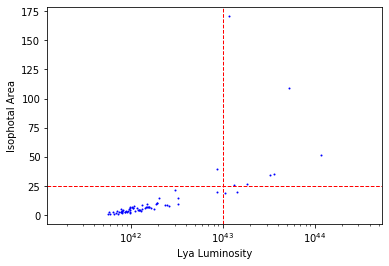

In [77]:
plt.semilogx()
plt.scatter(emitter_1.luminosity,emitter_1.ISOAREAF_IMAGE*(0.0625), color = 'b', s=1)
plt.axhline(25, color='r', linestyle='--', linewidth = 1)
plt.axvline(1e43, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [78]:
lya=pd.DataFrame()
for i in range(len(emitter_1)):
    if (emitter_1.luminosity.data.obj[i]> 1e43) and ((emitter_1.ISOAREAF_IMAGE.data.obj[i]*(0.0625))> 25):
        lya=pd.concat([lya,emitter_1.loc[i:i]],ignore_index = True)


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [79]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0  4294.9658  1517.7211   220.239141    39.831002   38.23180      9.325148   
1  3950.3486  2521.0220   220.270138    39.900723   95.76148     14.754920   
2  4669.4204  2542.5642   220.205042    39.902110  143.67110     18.071890   
3  2618.8066  4361.5835   220.390591    40.028646  105.05350     15.453990   
4  3050.4783  4710.2119   220.351413    40.052836   35.23396      8.952383   
5  2686.3018  5533.6152   220.384411    40.110035   53.71046     11.051570   
6  5634.1406  6787.6685   220.116347    40.196699  344.30310     27.974540   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ISOAREA_IMAGE  ISOAREAF_IMAGE  \
0   -3.9561       0.2649      0           69            300             411   
1   -4.9530       0.1673      0           42            451             551   
2   -5.3934       0.1366      0           40           1372            1742   
3   -5.0535       0.1598      0           54            447

In [80]:
#lya即为最后筛选出的所有LAB，下面要再算出surface brightness--nb?bw?cont_bw?

In [81]:
lya=pd.concat([lya,DataFrame(calculate_SB(lya.cont_bw.data.obj,4135,1278,lya.ISOAREAF_IMAGE.data.obj*0.0625))],axis=1)

lya.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','mag_bw','mag_nb','cont_bw','flux_bw','flux_nb','cont_flux_per_frequency','line_flux','luminosity','surface_brightness']
#???关于用到的surface brightness的delta_lambda什么的？

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [82]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0  4294.9658  1517.7211   220.239141    39.831002   38.23180      9.325148   
1  3950.3486  2521.0220   220.270138    39.900723   95.76148     14.754920   
2  4669.4204  2542.5642   220.205042    39.902110  143.67110     18.071890   
3  2618.8066  4361.5835   220.390591    40.028646  105.05350     15.453990   
4  3050.4783  4710.2119   220.351413    40.052836   35.23396      8.952383   
5  2686.3018  5533.6152   220.384411    40.110035   53.71046     11.051570   
6  5634.1406  6787.6685   220.116347    40.196699  344.30310     27.974540   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ...  ISOAREAF_IMAGE     mag_bw  \
0   -3.9561       0.2649      0           69  ...             411  21.536481   
1   -4.9530       0.1673      0           42  ...             551  22.187781   
2   -5.3934       0.1366      0           40  ...            1742  20.747781   
3   -5.0535       0.1598      0           54  ...      

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



x_image: 4294.9658 

y_image: 1517.7211 

RA: 220.23914059999998 

DEC: 39.8310023 

continuum_bw_magnitude 25.298607624527143 

surface_brightness: 3.851732999530816e-16 



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will

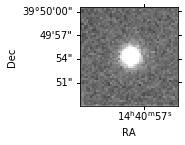

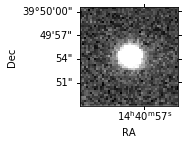

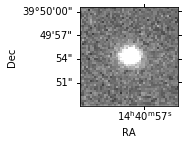

In [83]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[0],lya.Y_IMAGE.data.obj[0],25)

print('x_image:',lya.X_IMAGE.data.obj[0],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[0],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[0],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[0],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[0],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[0],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[0],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[0],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 3950.3486 

y_image: 2521.022 

RA: 220.2701377 

DEC: 39.9007231 

continuum_bw_magnitude 25.683671085857405 

surface_brightness: 2.0152132634667656e-16 



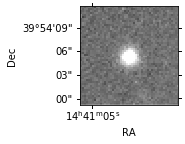

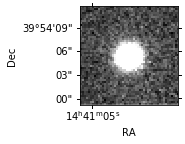

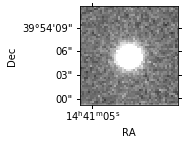

In [84]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[1],lya.Y_IMAGE.data.obj[1],25)

print('x_image:',lya.X_IMAGE.data.obj[1],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[1],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[1],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[1],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[1],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[1],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[1],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[1],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 4669.4204 

y_image: 2542.5642 

RA: 220.2050418 

DEC: 39.9021096 

continuum_bw_magnitude 26.115570488918344 

surface_brightness: 4.282177841359913e-17 



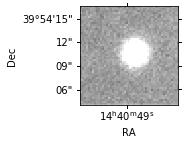

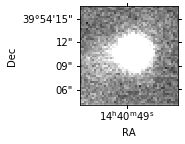

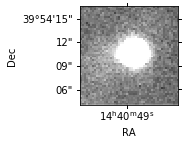

In [85]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[2],lya.Y_IMAGE.data.obj[2],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

In [86]:
with open("BOSS1441_cut.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(lya)):
        txtfile.write('circle(')
        txtfile.write(str(lya.ALPHA_J2000.data.obj[i]))
        txtfile.write(',')
        txtfile.write(str(lya.DELTA_J2000.data.obj[i]))
        txtfile.write(',2.821")\n')
    
    #把他们的RA和DEC写到目录里面方便查阅

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will be removed in a future version



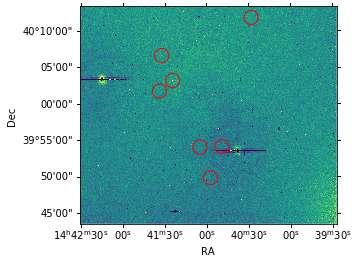

<Figure size 432x288 with 0 Axes>

In [87]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, color='', marker='o', edgecolors='r', s=200)

In [88]:
#现在注意一下，Bw_2,NB_2代表LAE，而lya代表LAB

In [89]:
def Gaussian2D(r, sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-r**2/2/sigma**2)

def f_i(i, x, sigma):
    x1 = np.delete(x, i, axis=1)
    r = np.sqrt((x[0][i]-x1[0])**2 + (x[1][i]-x1[1])**2)
    Sum = np.sum(Gaussian2D(r, sigma))
    return Sum

def Likelyhood(x, sigma):
    list = [f_i(i, x, sigma) for i in range(len(x[0]))]
    Prod = np.prod(list)
    return Prod

In [90]:
hdu1 = fits.open('bwcut.fits')[0]
wcs1 = WCS(hdu1.header)#; hdu1.close()

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



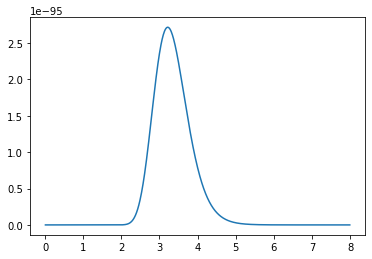

sigma is 3.31 [arcmin]


In [91]:


ra, dec = wcs1.all_pix2world(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj,1)
emitter=np.vstack([60*ra, 60*dec])#把度转换成arcmin

step = 0.01
sigma = np.arange(step, 8, step)
Lh = [Likelyhood(emitter, s) for s in sigma]
plt.plot(sigma,Lh)
# plt.semilogy()
plt.show()

Sigma = Lh.index(max(Lh))*step+0.1
print('sigma is {}'.format(Sigma),'[arcmin]')
#求出做高斯分布的sigma

In [92]:
print(ra)
print(dec)

[219.95407993 220.12727749 220.2511587  220.34716642 219.98201981
 220.3012468  220.52757992 220.17373267 220.15739345 220.55479467
 219.94958796 220.31629523 220.23914809 220.05614849 220.55141413
 219.94658172 219.95292358 220.62136729 220.49412583 219.95551529
 220.0833257  220.22603816 220.46815076 220.37809433 220.47922891
 220.33499623 220.27015697 220.27045892 220.20499166 220.03777214
 220.04582017 220.29829857 219.96816783 220.04672875 220.1059696
 220.31372168 220.12117472 220.54466249 220.36647842 220.47581683
 220.35690903 220.40872314 220.3666099  220.27907903 220.39061466
 220.21124114 220.41683804 220.53779945 220.35250309 220.53891853
 220.34028127 219.95388443 220.35536615 220.35144626 220.06055363
 220.44176356 220.16507987 219.90485122 220.32020681 220.49203423
 220.38442645 220.12844716 220.62803449 219.94204718 219.99959764
 219.87970091 220.04119756 220.12260843 220.06931749 220.14173332
 220.1163835 ]
[39.73687667 39.7456259  39.75441854 39.76234965 39.77335388 3

In [93]:
print(emitter)#就是把ra和dec用np.vstack放到了一个dataframe里，第一行ra，第二行dec

[[13197.24479555 13207.63664967 13215.06952205 13220.8299851
  13198.92118841 13218.07480776 13231.65479503 13210.42396031
  13209.44360671 13233.28768036 13196.97527742 13218.97771402
  13214.34888524 13203.36890928 13233.08484775 13196.79490332
  13197.17541464 13237.28203717 13229.64754989 13197.33091753
  13204.99954199 13213.56228966 13228.08904574 13222.68566003
  13228.75373451 13220.09977379 13216.20941797 13216.22753498
  13212.29949957 13202.2663282  13202.74921009 13217.89791398
  13198.09006963 13202.80372482 13206.35817587 13218.82330076
  13207.27048299 13232.67974949 13221.9887051  13228.54900976
  13221.41454204 13224.52338862 13221.99659391 13216.74474176
  13223.43687988 13212.67446825 13225.01028245 13232.26796685
  13221.15018528 13232.33511188 13220.41687618 13197.23306597
  13221.32196917 13221.08677581 13203.63321807 13226.50581334
  13209.90479238 13194.29107332 13219.2124088  13229.52205362
  13223.06558727 13207.70682966 13237.68206968 13196.52283105
  13199.9

In [94]:
len_ra=wcs1.array_shape[0]*0.25/60
len_dec=wcs1.array_shape[1]*0.25/60

area=len_ra*len_dec
print(area,'arcmin**2')
#求整个field的面积，0.25是单个pixel对应的arcsec长度,再除60就是arcmin的长度了

1049.18578125 arcmin**2


In [95]:
ave_density=len(NB_2)/area
print('average density:',ave_density)

average density: 0.06767152326007564


In [96]:
#np.meshgrid() 生成网格，类似于
#x = np.array([[0, 1, 2], [0, 1, 2]])
#y = np.array([[0, 0, 0], [1, 1, 1]])
#x是每一列的每个格点重复一遍x坐标，第一列的两个点都是0，第二列的两个都是1，...以此类推
#y则是每行都一样，第一行的y坐标都是0，第二行的y坐标都是1......注意虽然y看起来是下面那行是1，其实1还是上面那行对应的
#结果就等于两个矩阵重合组合一下，每个点就分别有了x坐标和y坐标

In [97]:
#np.arange()
#函数返回一个有终点和起点的固定步长的排列，如[1,2,3,4,5]，起点是1，终点是5，步长为1。
#参数个数情况： np.arange()函数分为一个参数，两个参数，三个参数三种情况
#1）一个参数时，参数值为终点，起点取默认值0，步长取默认值1。
#2）两个参数时，第一个参数为起点，第二个参数为终点，步长取默认值1。
#3）三个参数时，第一个参数为起点，第二个参数为终点，第三个参数为步长。其中步长支持小数

In [98]:
#np.vstack  按垂直方向（行顺序）堆叠数组构成一个新的数组
#eg.
#a = np.array([[1,2,3]])
#b = np.array([[4,5,6]])
#c = np.vstack((a,b))
#输出结果为

#[[1 2 3]
# [4 5 6]]


In [99]:
#numpy.delete(arr,obj,axis=None)
#arr:输入向量
#obj:表明哪一个子向量应该被移除。可以为整数或一个int型的向量
#axis:表明删除哪个轴的子向量，若默认，则返回一个被拉平的向量

In [100]:
#wcs1.array_shape[0] 等于是求这一行或者列的长度啦

In [101]:
binwidth = 100# sampling step
xx, yy = np.meshgrid(np.arange(0, wcs1.array_shape[0], binwidth), np.arange(0, wcs1.array_shape[1], binwidth))
#这一步就是分成100个区域-----一万个？貌似是一万个
ra_xx, dec_yy = wcs1.all_pix2world(xx+binwidth/2, yy+binwidth/2, 1)
#把这几个区域的中心做出来，一开始是用pixel的x和y值表示的，然后用wcs1.all_pix2world转化成用ra与dec表示
ra_xx, dec_yy = 60*ra_xx, 60*dec_yy
#再乘60，单位变成arcmin


In [102]:
f = [Gaussian2D(np.sqrt((ra_xx - emitter[0, i])**2 + (dec_yy - emitter[1, i])**2), Sigma) for i in range(len(emitter[0]))]
#这样做出来的f中的每一行，都是1个emitter对于1w个天区做高斯平滑后得到的单独个数分布


In [103]:
f = np.sum(f, axis=0)/abs(ra_xx[0, 1]-ra_xx[0, 0])/abs((dec_yy[1, 0]-dec_yy[0, 0]))#/ave_density
#把所有的这些单独分布求和，加起来，就得到总的分布，然后再除以此单个天区的面积，就得到了他在此天区中的数密度分布，再除以平均密度，就是相对的average density

In [104]:
#field用Mpc表示面积和volume，就是一个已知半径和角度求弧长的问题

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:251: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



[0, 7100, 0, 8400]

<Figure size 576x576 with 0 Axes>

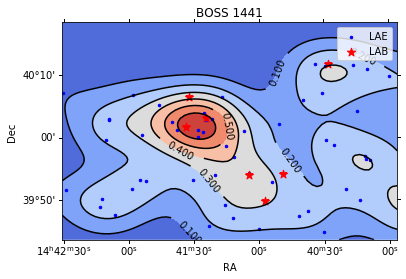

In [105]:
fig = plt.figure(figsize=(8, 8))
fig = plt.figure()
ax = fig.gca(projection=wcs1)

cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)

ax.scatter(emitter_1.X_IMAGE.data.obj, emitter_1.Y_IMAGE.data.obj, marker='.', color='blue', s=25, label='LAE')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, marker='*', color='r', s=75, label='LAB')
ax.legend()

ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

plt.title('BOSS 1441')

plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])

In [106]:
redshift_z=((4030-1215.7)/1215.7)

In [107]:
radii_z=cosmo.comoving_distance(2.3)#半径

In [108]:
angle_ra=len_ra/60
angle_dec=len_dec/60
#角度

In [109]:
length_ra=(angle_ra/180)*np.pi*radii_z
length_dec=(angle_dec/180)*np.pi*radii_z
area_field=length_ra*length_dec

In [110]:
redshift1=redshift_z+45/2/1215.7
redshift2=redshift_z-45/2/1215.7
velA=(30000/490)*((redshift1/(redshift1+1))-(redshift2/(redshift2+1)))
velB= cosmo.comoving_distance(redshift_z+45/2/1215.7)-cosmo.comoving_distance(redshift_z-45/2/1215.7)
#所以说红移场的深度就是和这个bandwidth相关的吗？45是bandwidth，因为4030在中心，所以要除以2出来

In [111]:
print((redshift1/(redshift1+1))-(redshift2/(redshift2+1)))

print(velA)
print(velB)

0.003368545174589843
0.20623745966876592
47.91952902709454 Mpc


In [134]:
v1=redshift1*3e5
v2=redshift2*3e5
d1=v1/490
d2=v2/490
velC=d1-d2
print(velC)

22.66268027322826


In [112]:
volume=velA*area_field
print('field volume:',volume)

field volume: 596.809263584259 Mpc2


In [113]:
#np.power(x,y) 求x的y次方

In [114]:
binwidth = 0.2#luminosity每隔10e0.2划分一个bin

In [115]:
mag = np.log10(emitter_1['luminosity'])
#等于这个是取上面的指数，因为我们最后的坐标就是指数的坐标

In [116]:
exponent=np.arange(binwidth*(min(mag)//binwidth-1), binwidth*(max(mag)//binwidth+1), binwidth)
print(exponent)
print(len(exponent))

[41.4 41.6 41.8 42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8 44. ]
14


In [117]:
y_lumi_func=np.histogram(mag, bins=exponent)[0]/volume.value
#数密度,即y轴坐标

In [118]:
print(np.histogram(mag, bins=exponent)[0])
print(np.histogram(mag, bins=exponent)[1])

print(len(np.histogram(mag, bins=exponent)[0]))
print(len(np.histogram(mag, bins=exponent)[1]))
#没错，就是要少一个，因为是在区间里面！

[ 0  3 25 20  8  4  0  2  4  1  2  1  0]
[41.4 41.6 41.8 42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8 44. ]
13
14


In [119]:
x_lumi_func = np.power(10,np.arange(binwidth*(min(mag)//binwidth-1)+0.1, binwidth*(max(mag)//binwidth+1)-0.1, binwidth))
#x轴坐标来了！这里要注意一下把它变成和y轴一样多的，就是去两个区间中间的值！


In [120]:
print(len(x_lumi_func))
print(len(y_lumi_func))
#这样就对齐了！可以操作了！

13
13


In [121]:
lumi_func = np.delete(np.vstack([x_lumi_func, y_lumi_func]), np.where(y_lumi_func==0) ,axis=1)

In [122]:
print(lumi_func)

[[5.01187234e+41 7.94328235e+41 1.25892541e+42 1.99526231e+42
  3.16227766e+42 7.94328235e+42 1.25892541e+43 1.99526231e+43
  3.16227766e+43 5.01187234e+43]
 [5.02673163e-03 4.18894302e-02 3.35115442e-02 1.34046177e-02
  6.70230883e-03 3.35115442e-03 6.70230883e-03 1.67557721e-03
  3.35115442e-03 1.67557721e-03]]


In [123]:
error = np.sqrt(lumi_func[1]*volume.value)/volume.value#误差

In [124]:
def LuminoFunc(x, a, b, c):
    return (a)*np.power(x/b,c) *np.exp(-x/b)
#luminosity function的定义


def LuminoFunc1(x, a, b, c):
    return (a)*np.power(x,c) *np.exp(-x)

#这第二个是啥回来再说

In [125]:
#def func(x,B,n):
#    return B*x**n
#param_bounds=([-np.inf,0],[np.inf,1])
#设定B和n的下界和上界。其中B为负无穷到正无穷，n为0到1，即第一个list是全部参数的上界，第二个list是全部参数的下界
#r2=optimize.curve_fit(func,x,y,bounds=param_bounds)
#B,n=r2[0]#输出拟合的参数

In [126]:
param_bounds =([10**-7., 10**40., -2], [1, 10**44., -1.0])

In [127]:
popt_1, pcov_1 = curve_fit(LuminoFunc, lumi_func[0], lumi_func[1], p0=[10**(-4), 10**42.4, -1.3], bounds=param_bounds, maxfev=50000)


In [128]:
print(popt_1)#三个参数的值
#pcov_1 不知道是啥，大概率没用

[ 3.96894469e-03  2.51188643e+42 -1.30000029e+00]


In [129]:
a = popt_1[0]; b = popt_1[1]; c = popt_1[2]; print('phi*=', a); print('L*=', b); print('alpha=', c)
xvals = np.linspace(10**41.5, 10**43,200)
yvals = LuminoFunc(xvals, a, b, c)

a0, b0, c0 = 10**(-2.86), 10**42.33, -1.65 #constant at z=2.3
# a0, b0, c0 = 10**(-3.96), 10**43.22, -1.72 #constant at z=2.3
v, err = integrate.quad(LuminoFunc, 0.65, 1000, args=(a0, b0, c0)) # N_field
# print('err=',err)
# v = v * 15**3; print('random field Lya number density:', v, '/Mpc3')

phi*= 0.003968944685798536
L*= 2.511886431509572e+42
alpha= -1.300000288811453


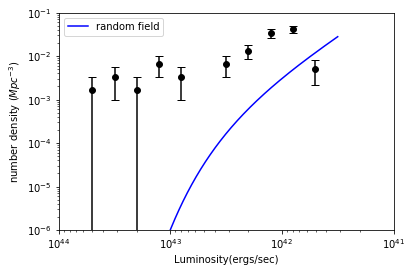

In [130]:
fig,ax = plt.subplots()
plt.semilogx()
plt.semilogy()

plt.scatter(lumi_func[0], lumi_func[1], color = 'black', edgecolors='black', marker='o', s=35)
plt.errorbar(lumi_func[0], lumi_func[1], fmt='None', yerr=error, ecolor='black', capsize=4)
plt.plot(xvals, LuminoFunc(xvals, a0, b0, c0), color='b', label='random field')

ax.set_xlim(10e43,10e40)
ax.set_ylim(10e-7,10e-2)

ax.invert_xaxis()

plt.xlabel('Luminosity(ergs/sec)')
plt.ylabel('number density ($Mpc^{-3}$)')
plt.legend()
